In [1]:
from datetime import datetime
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected = True)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

# Use https://nbviewer.org/ 
To view the plotly graphs.

In [2]:
url = "https://www.techpowerup.com/gpu-specs/"

This is a top 50 of the most popular, or searched for GPUs in this particular site, it has the basic info of almost all GPUs.

In [3]:
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
# Taking all HTML content stored on site

### soup.find_all(class_="processors")
This finds way too much, also would take up alot of space to display so would like to narrow down the details

Therefore we can't look for things by class or id. Will have to try something else.


In [4]:
table = soup.findChildren('table')[1]
# Locates only the tables, where there are 2, I see the second one being the actual table needed for the data
headers = table.findChildren(['tr'])[1]
# Heading for each GPU, the name, type, date released, and in depth info.
headers

<tr>
<th>Product Name</th>
<th>GPU Chip</th>
<th>Released</th>
<th>Bus</th>
<th>Memory</th>
<th>GPU clock</th>
<th>Memory clock</th>
<th>Shaders / TMUs / ROPs</th>
</tr>

In [5]:
x = []
for i in table.find_all(['th'])[1:]:
    x.append(i.text.replace('\n', ' ').strip())
x

['Product Name',
 'GPU Chip',
 'Released',
 'Bus',
 'Memory',
 'GPU clock',
 'Memory clock',
 'Shaders / TMUs / ROPs']

In [6]:
y = []
for i in table.find_all("td"):
    y.append(i.text.replace('\n', ' ').strip())
y[:8], y[-8:]

(['GeForce RTX 3090 Ti',
  'GA102',
  'Jan 27th, 2022',
  'PCIe 4.0 x16',
  '24 GB, GDDR6X, 384 bit',
  '1560 MHz',
  '1313 MHz',
  '10752 / 336 / 112'],
 ['GeForce RTX 4060',
  'AD104',
  '2022',
  'PCIe 4.0 x16',
  '12 GB, GDDR6, 192 bit',
  '1925 MHz',
  '2250 MHz',
  '5888 / 184 / 64'])

Now with all the data split, need to create a new array to store as a df.

We know there are 8 different columns per GPU, now it would be nice to know how many GPUs make the popular section.

As we know in this page, all the GPUs are split by tr html tags, we have a title, then the column names afterwards each tr encapsulates a row from the table.

So looking past the first 2 tr tags, we have the remainder.


In [7]:
len(table.findChildren(['tr'])[2:])

# We have 50 GPUs on the popular section.

50

In [8]:
# So since we have the number of columns, 8, number of GPUs, 50
# We can reshape the data to our liking.
stats = np.reshape(y, (50,8))

In [9]:
df = pd.DataFrame(stats, columns=x)
df.head()

,Product Name,GPU Chip,Released,Bus,Memory,GPU clock,Memory clock,Shaders / TMUs / ROPs
0,GeForce RTX 3090 Ti,GA102,"Jan 27th, 2022",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1560 MHz,1313 MHz,10752 / 336 / 112
1,GeForce RTX 3060,GA106,"Jan 12th, 2021",PCIe 4.0 x16,"12 GB, GDDR6, 192 bit",1320 MHz,1875 MHz,3584 / 112 / 48
2,GeForce RTX 3060 Ti,GA104,"Dec 1st, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1410 MHz,1750 MHz,4864 / 152 / 80
3,GeForce RTX 3090,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1395 MHz,1219 MHz,10496 / 328 / 112
4,GeForce RTX 3050 8 GB,GA106,"Jan 4th, 2022",PCIe 4.0 x8,"8 GB, GDDR6, 128 bit",1552 MHz,1750 MHz,2560 / 80 / 32


In [10]:
# To split the Shaders, TMUs, ROPs stats. 
df[['Shaders', 'TMUs', 'ROPs']] = df["Shaders / TMUs / ROPs"].str.split(' / ', expand=True).astype(float)
df.head()

,Product Name,GPU Chip,Released,Bus,Memory,GPU clock,Memory clock,Shaders / TMUs / ROPs,Shaders,TMUs,ROPs
0,GeForce RTX 3090 Ti,GA102,"Jan 27th, 2022",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1560 MHz,1313 MHz,10752 / 336 / 112,10752.0,336.0,112.0
1,GeForce RTX 3060,GA106,"Jan 12th, 2021",PCIe 4.0 x16,"12 GB, GDDR6, 192 bit",1320 MHz,1875 MHz,3584 / 112 / 48,3584.0,112.0,48.0
2,GeForce RTX 3060 Ti,GA104,"Dec 1st, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1410 MHz,1750 MHz,4864 / 152 / 80,4864.0,152.0,80.0
3,GeForce RTX 3090,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1395 MHz,1219 MHz,10496 / 328 / 112,10496.0,328.0,112.0
4,GeForce RTX 3050 8 GB,GA106,"Jan 4th, 2022",PCIe 4.0 x8,"8 GB, GDDR6, 128 bit",1552 MHz,1750 MHz,2560 / 80 / 32,2560.0,80.0,32.0


Was going to add in columns, then iterate over the existing entries while converting my strings to integers, but thats redundant and not as efficient as the simple line above.

In [11]:
df.drop(df[df['Memory'] == "System Shared"].index, inplace = True)

In [12]:
#def find_faults(names):
#    x = []
#    for i in range(len(names)):
#        if df["Memory"][i] == "System Shared":
#            x.append(df["Product Name"][i])
#        else:
#            continue
#    return x
#find_faults(df)

#plt.figure(figsize=(15, 8))
#plt.bar(df["Product Name"], df["Memory clock(MHz)"].astype(float))
#plt.xticks(rotation=90)
#plt.show()

#Cant run this automatically, have to adjust since there is a system shared'
#Located on Radeon vega 8 is an all in one GPU, have to remove it.

In [13]:
#df.rename(columns={'GPU clock': 'GPU clock(MHz)', 'Memory clock': 'Memory clock(MHz)'})
df['GPU clock(MHz)'] = [float(i.replace(" MHz", "")) for i in df['GPU clock']]
df['Memory clock(MHz)'] = [float(i.replace(" MHz", "")) for i in df['Memory clock']]
df.head()

,Product Name,GPU Chip,Released,Bus,Memory,GPU clock,Memory clock,Shaders / TMUs / ROPs,Shaders,TMUs,ROPs,GPU clock(MHz),Memory clock(MHz)
0,GeForce RTX 3090 Ti,GA102,"Jan 27th, 2022",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1560 MHz,1313 MHz,10752 / 336 / 112,10752.0,336.0,112.0,1560.0,1313.0
1,GeForce RTX 3060,GA106,"Jan 12th, 2021",PCIe 4.0 x16,"12 GB, GDDR6, 192 bit",1320 MHz,1875 MHz,3584 / 112 / 48,3584.0,112.0,48.0,1320.0,1875.0
2,GeForce RTX 3060 Ti,GA104,"Dec 1st, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1410 MHz,1750 MHz,4864 / 152 / 80,4864.0,152.0,80.0,1410.0,1750.0
3,GeForce RTX 3090,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1395 MHz,1219 MHz,10496 / 328 / 112,10496.0,328.0,112.0,1395.0,1219.0
4,GeForce RTX 3050 8 GB,GA106,"Jan 4th, 2022",PCIe 4.0 x8,"8 GB, GDDR6, 128 bit",1552 MHz,1750 MHz,2560 / 80 / 32,2560.0,80.0,32.0,1552.0,1750.0


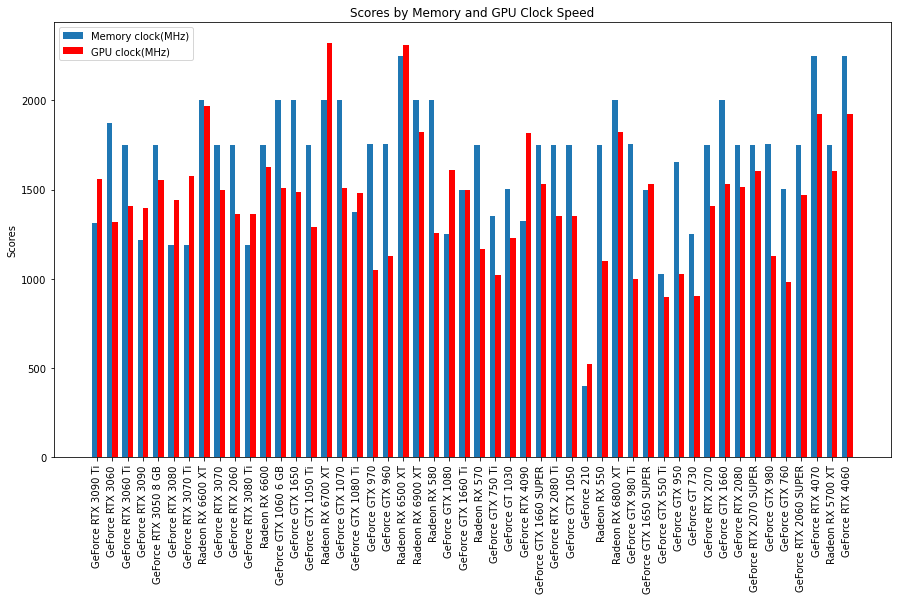

In [14]:
# Simple chart to see the differences of Memory Clock speed in the most searched GPUs
# Obviously there is some bias as most people want to know the newest ones, but there are definitely
# some older models thrown into the mix.

labels = df["Product Name"]
mem_clock = df["Memory clock(MHz)"]
gpu_clock = df["GPU clock(MHz)"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mem_clock, width, label="Memory clock(MHz)")
rects2 = ax.bar(x + width/2, gpu_clock, width, label="GPU clock(MHz)", color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Memory and GPU Clock Speed')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.xticks(rotation=90)
fig.set_size_inches(15,8)
plt.show()

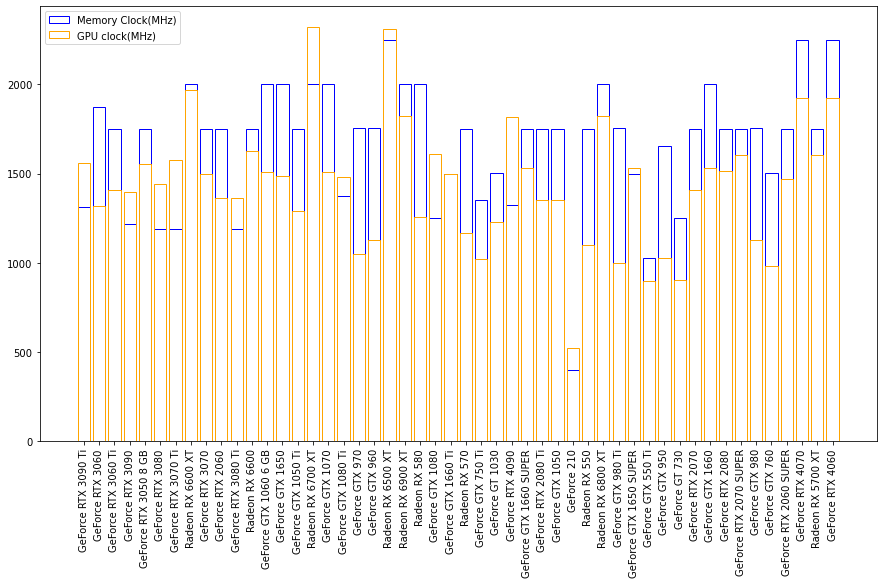

In [15]:
plt.figure(figsize=(15, 8))
plt.bar(df["Product Name"], df["Memory clock(MHz)"], edgecolor='blue', color='None')
plt.bar(df["Product Name"], df["GPU clock(MHz)"],  edgecolor='orange', color='None')
plt.xticks(rotation=90)

plt.legend(["Memory Clock(MHz)", "GPU clock(MHz)"])
plt.show()

So we have 2 graphs here, both depicting the same information of comparisons between the top 50 GPUs Memory and GPU Clock Speed.

We can see that generally Memory Clock Speed is higher then GPU Clock Speed. Generally speaking there isn't much of a reason why that is the case, both are quite important in overall performance as explained below.


# TL;DR
    - GPU clock is the speed of the actual GPUs chip, FPS (Frames per Second)
    - Memory clock is the speed of the VRAM on the GPU, Image Quality
    - Usually core clock affects gaming performance more than memory clock does.
# Core Clock
Core clock (GPU clock) refers to the speed of the cores on the Graphics processor. Cores on a GPU are very similar to cores on a CPU. However GPUs are made to do one thing, render graphics and assets, just like how cores on a CPU handles tasks as a "Jack of All Trades".

The core clock will make a difference in how many frames per second that you are able to play games on, but is not as important as memory clock when it comes to image quality or resolution. The core clock can also be increased by adding more graphics card or overclocking an existing one if base speeds are not high enough.

A higher core clock speed will provide you with a better frame rate, meaning that you will be able to play games on higher settings, but you also need to balance the gpu memory clock speed with it as well in order to keep the image quality at a high level.
# Memory Clock
Memory Clock is the frequency of the VRAM on the GPU where VRAM is the RAM utilized by the GPU. It is used to hold memory for assets that the GPU needs to render such as “hold the shading textures for these trees.” VRAM clocks in frequencies, faster frequencies means the faster the ram can take, hold, or replace short term information. 

Unlike your hard drive or SSD, the information is moving back and forth like standard DRAM(The ram sticks that you put on your motherboard)|, deleted and replaced, all of the time. So memory needs much higher frequencies than your typical storage device but just like computer RAM the capacity is much smaller. 

This number will mainly affect how fast your graphics are displayed on screen, so with a low GPU Memory Clock Speed, games or other graphics-intense tasks may not be able to display as smoothly.
# Conclusion
The main difference between the two is that the graphics processor core clock will dictate how quickly it can perform calculations, while the memory clock dictates what data is available to be processed. Essentially your computer needs enough VRAM in order for you to complete any given task on a graphically intensive game or program without inconveniences such as lagging frames and choppy gameplay. 

At the end of the day a higher than necessary gpu memory clock speed might not help if there’s not enough VRAM and it could lead to performance issues. Vice versa.


In [16]:
dfbox1 = df.copy()
dfbox1.drop(dfbox1[dfbox1['Product Name'] == "GeForce 210"].index, inplace = True)
fig1 = px.box(dfbox1, y= ["Memory clock(MHz)", "GPU clock(MHz)"])
fig1.show()

If we remove our single outlier the GeForce 210 which is located at the bottom in terms of both Memory and GPU speed. 
Also the single outlier AMDs Radeon RX 6700XT it is presented in the GPU clock but not in the Memory so we'll keep that in. 

We can see in comparison to our bar charts a similar output here in our box plots. The Memory Clock spread is relatively low with a 900 - 2000 spread, while the GPU Clock has a 675 - 1968 spread. Considering what both speeds stand for it seems GPU clock speed is harder to develop in comparison to Memory speeds. Memory speeds have the higher mean, median, Q1 and Q3. Then it should be said that a 1500+ Memory speed should be the only GPUs sought after in the market then.

In [17]:
# Shaders has too much variance, and it makes the box plot look really can't see TMU or ROPs
#fig2 = px.box(df, y =["Shaders", "TMUs", "ROPs"])
fig2 = px.box(df, y =["TMUs", "ROPs"])
fig2.show()

In [18]:
df.skew()

Shaders              2.101397
TMUs                 1.413572
ROPs                 1.056922
GPU clock(MHz)       0.206305
Memory clock(MHz)   -1.035328
dtype: float64

So by looking at the Skewness of our various categories, we can see that majority of them are highly skewed, at values greater/lower then 1/-1 meaning the distribution curve is not symmetrical which we will see in histograms.

A positive skew indicates values are lower then the average.
A negative skew indicates values are higher then the average. 

Overall this just indicates that the values aren't following a Normal distribution, we have values all over the place and not neatly in a bell shape. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2942C448>,
      dtype=object)

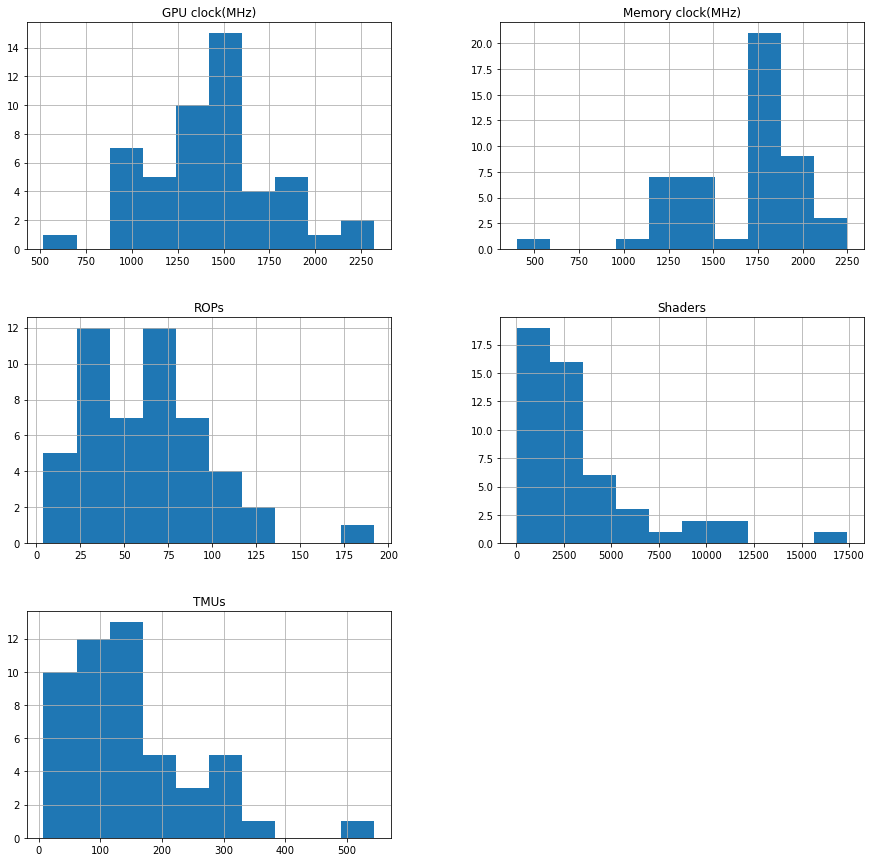

In [19]:
df.hist(figsize=(15,15))

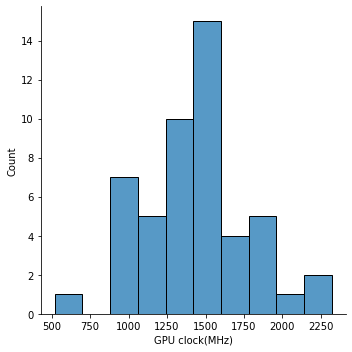

In [20]:
# Just a nicer looking plot of the least skewed data we have.
sns.displot(df['GPU clock(MHz)'])

In [21]:
fig = px.pie(df, names="Bus", title='Percentages of GPUs PCIe Capability', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

From the Pie chart above, we can see that majority of PC's are under PCIe 3.0 x 16, which is not a big surprise as from approximately 2015-2019 the 1000 & 2000 series were introduced. This included 1050-1080, 2060-2080, the respective cards as well as the Ti editions all under the Turing architecture. Of course this is not including AMD's competing Radeon graphics cards. 

As these cards were an evolutionary part of the GPU industry, they are still indeed relevant and are listed in the top 50 as shown above.

Focus on  PCIe 3.0 x 16 taking up over half of all capacity

The "Modern/Sought After" GPUs: PCIe 4.0 x 16 is something everyone wants

In [22]:
df["Released"].str.split(' ', expand=True).head()

,0,1,2
0,Jan,"27th,",2022
1,Jan,"12th,",2021
2,Dec,"1st,",2020
3,Sep,"1st,",2020
4,Jan,"4th,",2022


In [23]:
"""for i in df["Released"].str.split(' ', expand=True)[2]:
    if i == None:
        continue
    else:
        print(i)"""

# This just prints out each year of the GPU, potentially use date as a variable down the road

'for i in df["Released"].str.split(\' \', expand=True)[2]:\n    if i == None:\n        continue\n    else:\n        print(i)'

In [24]:
# If bus is PCIe = 4.0 x 16, then we know its a relatively modern and competitive/Sought-after GPU

# Machine Learning Algorithm
Here we start classifying our data, we know that there are a few sections to consider. Generally speaking PCIe 3.0 x 16 and everything at PCIe 4.0 is considered modern and still top of the line graphics capabilities. The PCIe 3.0 x 8 graphics cards are also considered useable, however as these cards are not as sought after we will consider them as not modern to even out the split.

In [25]:
df['Sought After'] = [1 if "PCIe 4.0" in i else 0 for i in df['Bus']]
#df["Useable"] = df["Bus"].map({"PCIe 4.0 x16":1, "PCIe 4.0 x8":1, "PCIe 3.0 x16":1, "PCIe 3.0 x8" : 0,
#                             "PCIe 3.0 x4" : 0, "PCIe 2.0 x16" : 0, "PCIe 2.0 x8": 0 })
df.head()

,Product Name,GPU Chip,Released,Bus,Memory,GPU clock,Memory clock,Shaders / TMUs / ROPs,Shaders,TMUs,ROPs,GPU clock(MHz),Memory clock(MHz),Sought After
0,GeForce RTX 3090 Ti,GA102,"Jan 27th, 2022",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1560 MHz,1313 MHz,10752 / 336 / 112,10752.0,336.0,112.0,1560.0,1313.0,1
1,GeForce RTX 3060,GA106,"Jan 12th, 2021",PCIe 4.0 x16,"12 GB, GDDR6, 192 bit",1320 MHz,1875 MHz,3584 / 112 / 48,3584.0,112.0,48.0,1320.0,1875.0,1
2,GeForce RTX 3060 Ti,GA104,"Dec 1st, 2020",PCIe 4.0 x16,"8 GB, GDDR6, 256 bit",1410 MHz,1750 MHz,4864 / 152 / 80,4864.0,152.0,80.0,1410.0,1750.0,1
3,GeForce RTX 3090,GA102,"Sep 1st, 2020",PCIe 4.0 x16,"24 GB, GDDR6X, 384 bit",1395 MHz,1219 MHz,10496 / 328 / 112,10496.0,328.0,112.0,1395.0,1219.0,1
4,GeForce RTX 3050 8 GB,GA106,"Jan 4th, 2022",PCIe 4.0 x8,"8 GB, GDDR6, 128 bit",1552 MHz,1750 MHz,2560 / 80 / 32,2560.0,80.0,32.0,1552.0,1750.0,1


In [26]:
#fig, axs = plt.subplots(5, figsize=(10, 15))
#axs[0].scatter(df["Shaders"], y)
#axs[0].set_title('Shaders')

#axs[1].scatter(df["TMUs"], y)
#axs[1].set_title('TMUs')
#axs[2].scatter(df["ROPs"], y)
#axs[2].set_title('ROPs')
#axs[3].scatter(df["GPU clock(MHz)"], y)
#axs[3].set_title('GPU Clock(MHz)')
#axs[4].scatter(df["Memory clock(MHz)"], y)
#axs[4].set_title("Memory Clock(MHz)")

In [27]:
# Actually really liking plotly interactive, alot more versatile and interactive.

In [28]:
fig = px.scatter(df, x="TMUs", y="Sought After", hover_data=['Product Name'])
fig.show()

In [29]:
fig = px.scatter(df, x="ROPs", y="Sought After", hover_data=['Product Name'])
fig.show()

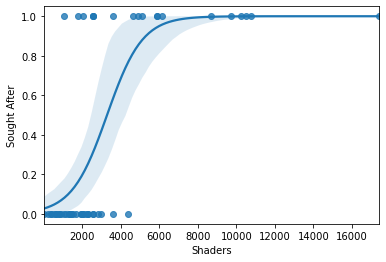

In [30]:
fig = px.scatter(df, x="Shaders", y="Sought After", hover_data=['Product Name'])
fig.show()
sns.regplot(x='Shaders', y='Sought After', data=df, logistic=True)

In [31]:
fig = px.scatter(df, x="Memory clock(MHz)", y="Sought After", hover_data=['Product Name'])
fig.show()

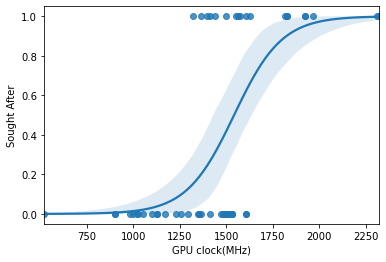

In [32]:
fig = px.scatter(df, x="GPU clock(MHz)", y="Sought After", hover_data=['Product Name'])
fig.show()
sns.regplot(x='GPU clock(MHz)', y='Sought After', data=df, logistic=True)

Generally all parameters aren't looking too good for determing a "modern" GPU.

GPU Clock and Shaders look to be our best bet in this classification problem.

# Logistic regression for determing which gpu is modern/relevant 

In [33]:
y = df["Sought After"]
x1 = df.loc[:, "GPU clock(MHz)"]

In [34]:
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x)
#model = LogisticRegression(solver='liblinear', random_state=0).fit(x, y)

In [35]:
results_log = reg_log.fit()
# Fit regressions in 8 iterations, 

Optimization terminated successfully.
         Current function value: 0.411967
         Iterations 8


In [36]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Sought After   No. Observations:                   50
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Apr 2022   Pseudo R-squ.:                  0.3796
Time:                        21:20:39   Log-Likelihood:                -20.598
converged:                       True   LL-Null:                       -33.203
Covariance Type:            nonrobust   LLR p-value:                 5.142e-07
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -12.0117      3.841     -3.127      0.002     -19.540      -4.484
GPU clock(MHz)     0.0078      0.003      3.047      0.002       0.003       0.013
==================================================================================
"""

Using the MLE method, i.e. finding a model to find the highest likelihood value.

Log-likelihood is more convenient, with a negative value of 19.429 we have a good model here

Our LLR p-value helps determine the significance of the model, with it being low it determines the model to be significant. 

-11.4486 + 0.0073 * GPU Clock(MHz)

With 0.0063 being the dependent variable, along with knowing the model following a Logit.

### $ exp(0.0073 \cdot x )$

Where x represents the number of GPU MHz increases

$ exp(0.0073 \cdot 1 ) = 1.007327$

Therefore when GPU clock speed increases by 1 MHz, the odds of the GPU being "Sought After" increases by .73%.


If GPU clock speed increases by 10 MHz, then the odds increases by 6.5%

$ exp(0.0063 \cdot 10 ) = 1.07573$

In [37]:
results_log.predict()

array([5.36036560e-01, 1.51128696e-01, 2.64159332e-01, 2.42073147e-01,
       5.20502879e-01, 3.12020617e-01, 5.64951505e-01, 9.65232627e-01,
       4.19909114e-01, 2.01794135e-01, 2.01794135e-01, 6.58966960e-01,
       4.31338501e-01, 3.91733279e-01, 1.24362120e-01, 9.97704260e-01,
       4.31338501e-01, 3.84331830e-01, 2.12541504e-02, 3.80630043e-02,
       9.97499312e-01, 9.01088563e-01, 9.82611619e-02, 6.24956192e-01,
       4.19909114e-01, 5.16507381e-02, 1.68984358e-02, 7.99758460e-02,
       8.93923041e-01, 4.77671126e-01, 1.83621088e-01, 1.88339689e-01,
       3.49141542e-04, 3.10654571e-02, 9.01088563e-01, 1.44951623e-02,
       4.77671126e-01, 6.70231382e-03, 1.74241249e-02, 6.80686946e-03,
       2.64159332e-01, 4.77671126e-01, 4.48616859e-01, 6.21296288e-01,
       3.80630043e-02, 1.24293580e-02, 3.64260862e-01, 9.52057232e-01,
       6.21296288e-01, 9.52057232e-01])

In [38]:
pred = np.array(results_log.predict() > 0.5, dtype=float)

In [39]:
np.array(df["Sought After"])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1], dtype=int64)

In [40]:
con_matrix = confusion_matrix(df['Sought After'], pred)
con_matrix

array([[29,  2],
       [ 6, 13]], dtype=int64)

In [41]:
con_matrix[0,0]/sum(con_matrix[:,0])

0.8285714285714286

In [42]:
con_matrix[1,1]/sum(con_matrix[:,1])

0.8666666666666667

So we can see that decent portion is correctly classified, we have a strong sensitivity rate correctly measuring sought after GPUs at 0.8257, while correctly identifying 0.87 true negatives. 

This model could be enhanced by adding in additional factors but a simple logistic regression based on GPU clock speed seems to do a decent job on its own!

In [43]:
# Supervised learning, Regression and classification
# Classification: Predicting an output category given input data,
# training a model on data then use it to predict future outcomes


# Clustering is grouping data points together based on similarities

In [44]:
# Unsupervised learning Cluster Analysis
# K mean clustering, recusrively finding closest points within
# the chart to determine seeds and clusters
# Implement n seeds, find points closest to assign to a seed
# Move the seeds to be a new centroid of its assigned points.
# Then again find closest points, relocate the centroid

# Clustering

In [45]:
df_values = df[["GPU clock(MHz)", "Memory clock(MHz)", "Sought After", "Product Name"]]
kmeans = KMeans(2)
kmeans.fit(df_values[["GPU clock(MHz)", "Memory clock(MHz)"]])

KMeans(n_clusters=2)

In [46]:
identified_clusters = kmeans.fit_predict(df_values[["GPU clock(MHz)", "Memory clock(MHz)"]])
identified_clusters

array([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1])

In [47]:
df_values["Cluster"] = identified_clusters
df_values.head()

<ipython-input-47-7ae981e2155e>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,GPU clock(MHz),Memory clock(MHz),Sought After,Product Name,Cluster
0,1560.0,1313.0,1,GeForce RTX 3090 Ti,0
1,1320.0,1875.0,1,GeForce RTX 3060,1
2,1410.0,1750.0,1,GeForce RTX 3060 Ti,1
3,1395.0,1219.0,1,GeForce RTX 3090,0
4,1552.0,1750.0,1,GeForce RTX 3050 8 GB,1


In [48]:
fig = px.scatter(df_values, x="GPU clock(MHz)",y="Memory clock(MHz)",
        color = "Cluster", hover_data = ["Product Name", "Sought After"])
fig.show()

In [50]:
confusion_matrix(df_values['Sought After'], identified_clusters)

array([[18, 13],
       [ 5, 14]], dtype=int64)

Well thats not too good

In [49]:
#Prediction

## Having TU - RTX 20 , GA - RTX 30, Navi - Radeon 6000s
# Maybe if its made in year 2019-21 would be best

# create a model, that predicts based on the stats, date and bus etc etc

# Do a random search or maybe ask the user to input somethign that then the model would have ot determine its capability 

# References 

https://www.fifthgeek.com/memory-clock/